In [1]:
#%pip install seaborn
#%pip install optuna
#%pip install optuna-integration
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
#%pip install lightning
#%pip install tensorflow

In [2]:
#CELL 1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
# import requests
# import pandas as pd
# import time

# def process_data_in_batches(url, csv_filename, batch_size=50000):
#     offset = 0
#     total_records = 0
    
#     while True:
#         # Construct the query URL with limit and offset
#         query_url = f"{url}?$limit={batch_size}&$offset={offset}"
        
#         # Make the API request
#         response = requests.get(query_url)
        
#         if response.status_code == 200:
#             data = response.json()
            
#             if not data:  # If no more data, break the loop
#                 break
            
#             # Convert batch to DataFrame
#             df = pd.DataFrame(data)
            
#             # Write batch to CSV
#             if offset == 0:
#                 df.to_csv(csv_filename, index=False, mode='w')
#             else:
#                 df.to_csv(csv_filename, index=False, mode='a', header=False)
            
#             records_in_batch = len(df)
#             total_records += records_in_batch
#             offset += batch_size
#             print(f"Processed {total_records} records so far...")
            
#             if records_in_batch < batch_size:
#                 # Last batch is smaller than batch_size, we're done
#                 break
#         else:
#             print(f"Error: {response.status_code}")
#             break
        
#         # Add a small delay to avoid overwhelming the server
#         time.sleep(1)
    
#     return total_records

# # URL of the API
# url = "https://data.austintexas.gov/resource/v7zg-5jg9.json"

# # CSV filename
# csv_filename = "austin_traffic_data.csv"

# # Process data in batches
# print("Fetching and processing data from API...")
# total_records = process_data_in_batches(url, csv_filename)

# print(f"\nTotal records processed and saved to {csv_filename}: {total_records}")

# # Print column names
# df = pd.read_csv(csv_filename, nrows=1)
# print(f"Columns: {', '.join(df.columns)}")


In [4]:
# Not needed as this dataset doesn't include enough streets to be useful
# import pandas as pd

# # Define the file name
# file_name = 'Radar_Traffic_Counts_20240816.csv'

# # Read the CSV file into a DataFrame
# try:
#     df = pd.read_csv(file_name)
#     print("File read successfully.")
# except Exception as e:
#     print(f"Error reading the file: {e}")
#     exit()

# # Display the first few rows of the DataFrame to inspect the data
# print("Initial DataFrame:")
# print(df.head())

# # List of columns to delete
# columns_to_delete = [
#     'Detector ID', 'KITS ID', 'Read Date',  
#     'Lane',  
#     'Hour', 'Minute', 'Day of Week', 'Time Bin'
# ]

# # Check if all columns to delete exist in the DataFrame
# missing_columns = [col for col in columns_to_delete if col not in df.columns]
# if missing_columns:
#     print(f"Columns not found in the DataFrame: {missing_columns}")
#     exit()

# # Filter rows where the "Year" column is not in the specified range
# valid_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
# df = df[df['Year'].isin(valid_years)]

# # Drop the specified columns
# df.drop(columns=columns_to_delete, inplace=True)

# # Display the first few rows of the modified DataFrame to inspect the changes
# print("Modified DataFrame:")
# print(df.head())

# # Keep only one row for each "Intersection Name" per month, with one of each direction (NB/EB/SB/WB)
# directions = ['NB', 'EB', 'SB', 'WB']
# filtered_df = pd.DataFrame()

# for direction in directions:
#     direction_df = df[df['Direction'] == direction]
#     grouped_df = direction_df.groupby(['Intersection Name', 'Year', 'Month']).first().reset_index()
#     filtered_df = pd.concat([filtered_df, grouped_df])

# # Display the first few rows of the filtered DataFrame to inspect the changes
# print("Filtered DataFrame:")
# print(filtered_df.head())

# # Save the filtered DataFrame back to the CSV file
# try:
#     filtered_df.to_csv(file_name, index=False)
#     print(f"Data in columns {columns_to_delete} has been deleted, rows with invalid years have been removed, and extra rows have been dropped.")
# except Exception as e:
#     print(f"Error saving the file: {e}")


In [5]:
#CELL 2
import pandas as pd
from datetime import datetime, timedelta

# Read the CSV files
work_done_df = pd.read_csv('work_done.csv')
grading_1_df = pd.read_csv('grading_1.csv')
grading_2_df = pd.read_csv('grading_2.csv')

# Read the Austin Crash Report Data CSV file
crash_data_df = pd.read_csv('Austin_Crash_Report_Data_-_Crash_Level_Records_20240809.csv')

# Extract the IDs from grading_1 and grading_2
grading_1_ids = set(grading_1_df['Segment ID'])
grading_2_ids = set(grading_2_df['Segment ID'])

# Combine the IDs from both grading files
combined_ids = grading_1_ids.union(grading_2_ids)

# Filter the rows in work_done_df where the ID in column B exists in combined_ids
filtered_work_done_df = work_done_df[work_done_df.iloc[:, 1].isin(combined_ids)]  # Assuming column B is the second column

# Extract relevant columns from grading_1 and grading_2
grading_1_relevant = grading_1_df[['Segment ID', 'Grade', 'Inspection ID', 'Functional Class']]
grading_2_relevant = grading_2_df[['Segment ID', 'Final_Grade', 'Year', 'Functional Class']]

# Rename columns for consistency
grading_1_relevant.columns = ['Segment ID', 'Grade', 'Inspection Year', 'Functional Class']
grading_2_relevant.columns = ['Segment ID', 'Grade', 'Inspection Year', 'Functional Class']

# Extract the year from the "Inspection ID" column in grading_1
grading_1_relevant['Inspection Year'] = grading_1_relevant['Inspection Year'].str.extract(r'(\d{4})').astype(float)

# Extract only the year from the "Year" column in grading_2
grading_2_relevant['Inspection Year'] = pd.to_datetime(grading_2_relevant['Inspection Year']).dt.year.astype(float)

# Combine the inspection data
combined_grading = pd.concat([grading_1_relevant, grading_2_relevant])

# Sort the combined data by Segment ID and Inspection Year
combined_grading = combined_grading.sort_values(by=['Segment ID', 'Inspection Year'], ascending=[True, False])

# Group by Segment ID and get the most recent, second most recent, and third most recent inspections
grouped = combined_grading.groupby('Segment ID').apply(lambda x: x.head(3)).reset_index(drop=True)

# Pivot the data to get the required columns
pivoted = grouped.pivot_table(index='Segment ID', columns=grouped.groupby('Segment ID').cumcount() + 1, values=['Inspection Year', 'Grade'], aggfunc='first')

# Flatten the MultiIndex columns
pivoted.columns = [f'{col[0]}_{col[1]}' for col in pivoted.columns]

# Merge the pivoted data with the filtered work_done_df
merged_df = filtered_work_done_df.merge(pivoted, left_on=filtered_work_done_df.columns[1], right_on='Segment ID', how='left')

# Extract the "Functional Class" column from both grading_1 and grading_2
functional_class_1 = grading_1_df[['Segment ID', 'Functional Class']].drop_duplicates()
functional_class_2 = grading_2_df[['Segment ID', 'Functional Class']].drop_duplicates()

# Merge the functional class data, giving priority to grading_1
functional_class = functional_class_2.merge(functional_class_1, on='Segment ID', how='left', suffixes=('_grading_2', '_grading_1'))
functional_class['Functional Class'] = functional_class['Functional Class_grading_1'].combine_first(functional_class['Functional Class_grading_2'])

# Merge the functional class data with the merged_df
merged_df = merged_df.merge(functional_class[['Segment ID', 'Functional Class']], on='Segment ID', how='left')

# Rename the columns for clarity
merged_df = merged_df.rename(columns={
    'Inspection Year_1': 'Most Recent Inspection Year',
    'Grade_1': 'Most Recent Inspection Grade',
    'Inspection Year_2': 'Second Most Recent Inspection Year',
    'Grade_2': 'Second Most Recent Inspection Grade',
    'Inspection Year_3': 'Third Most Recent Inspection Year',
    'Grade_3': 'Third Most Recent Inspection Grade'
})

# Convert the "Completion Date" column in work_done_df to datetime format
work_done_df['Completion Date'] = pd.to_datetime(work_done_df['Completion Date'])

# Find the latest "Completion Date" for each "Segment ID"
latest_dates = work_done_df.groupby('Segment ID')['Completion Date'].max().reset_index()

# Merge the latest dates with the merged_df
merged_df = merged_df.merge(latest_dates, on='Segment ID', how='left', suffixes=('', '_latest'))

# Calculate the number of days since the latest maintenance date for each row
merged_df['Days Since Last Maintenance'] = (datetime.now() - merged_df['Completion Date_latest']).dt.days

# Drop the extra date column
merged_df = merged_df.drop(columns=['Completion Date_latest'])

# Identify unique treatment categories
treatment_categories = work_done_df['Treatment'].unique()

# Create a function to count treatments
def count_treatments(group):
    counts = group['Treatment'].value_counts()
    return pd.Series({f"Number of {treatment} events": counts.get(treatment, 0) for treatment in treatment_categories})
def count_traffic_incidents(street_name, crash_data):
    return crash_data[(crash_data['street_name'].str.lower() == street_name.lower()) | 
                      (crash_data['street_name_2'].str.lower() == street_name.lower())].shape[0]


# Group by Segment ID and count treatments
treatment_counts = work_done_df.groupby('Segment ID').apply(count_treatments).reset_index()

# Merge the treatment counts with the merged_df
merged_df = merged_df.merge(treatment_counts, on='Segment ID', how='left')

# Remove the old "Number of Maintenance Events" column
#merged_df = merged_df.drop(columns=['Number of Maintenance Events'])

# Calculate the total number of maintenance events
merged_df['Total Maintenance Events'] = merged_df[[f"Number of {treatment} events" for treatment in treatment_categories]].sum(axis=1)
# Sort work_done_df by Segment ID and Completion Date
work_done_df = work_done_df.sort_values(['Segment ID', 'Completion Date'])

# Calculate time difference between consecutive maintenance events for each segment
work_done_df['Time Between Maintenances'] = work_done_df.groupby('Segment ID')['Completion Date'].diff().dt.days

# Drop duplicate rows based on 'Segment ID'
merged_df = merged_df.drop_duplicates(subset='Segment ID', keep='first')


# Add the "Number of traffic incidents" feature
merged_df['Number of traffic incidents'] = merged_df['Street Name'].apply(lambda x: count_traffic_incidents(x, crash_data_df))

# Drop the specified columns
columns_to_drop = ["From Limit Street", "To Limit Street", "Completion Date", "Resurfacing Description", "Treatment Category"]
merged_df = merged_df.drop(columns=columns_to_drop)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('filtered_work_done_with_inspections_and_treatments.csv', index=False)

# Display summary of the data
print(merged_df.head())
print(f"\nTotal number of unique segments: {len(merged_df)}")
print("\nColumns in the final dataframe:")
print(merged_df.columns.tolist())


# Calculate the percentage of correct predictions
total_segments = merged_df[['Most Recent Inspection Grade', 'Second Most Recent Inspection Grade']].notna().all(axis=1).sum()
correct_predictions = (merged_df['Most Recent Inspection Grade'] == merged_df['Second Most Recent Inspection Grade']).sum()
prediction_accuracy = (correct_predictions / total_segments) * 100 if total_segments > 0 else 0

# Display the results
print("\nPrediction Accuracy:")
print(f"Total segments with both grades: {total_segments}")
print(f"Correct predictions: {correct_predictions}")
print(f"Percentage of correct predictions: {prediction_accuracy:.2f}%")

# Display a breakdown of grade changes
grade_changes = merged_df[merged_df['Most Recent Inspection Grade'] != merged_df['Second Most Recent Inspection Grade']]
print("\nBreakdown of grade changes:")
print(grade_changes[['Second Most Recent Inspection Grade', 'Most Recent Inspection Grade']].value_counts().to_string())






# List of columns to drop
columns_to_drop = [
    'Second Most Recent Inspection Year',
    'Second Most Recent Inspection Grade',
    'Third Most Recent Inspection Year',
    'Third Most Recent Inspection Grade'
]

# Drop the specified columns from the DataFrame
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')

# Save the updated DataFrame to the CSV file
merged_df.to_csv('filtered_work_done_with_inspections_and_treatments.csv', index=False)

# Display the updated column list
print("\nUpdated columns in the final dataframe:")
print(merged_df.columns.tolist())

# Confirm that the specified columns have been removed
removed_columns = set(columns_to_drop) - set(merged_df.columns)
print("\nColumns successfully removed:")
print(removed_columns)

if len(removed_columns) != len(columns_to_drop):
    print("\nWarning: Some columns were not found in the DataFrame:")
    print(set(columns_to_drop) - removed_columns)



C:\Users\Zack\AppData\Local\Temp\ipykernel_27196\1304985260.py:11: DtypeWarning: Columns (7,53) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_data_df = pd.read_csv('Austin_Crash_Report_Data_-_Crash_Level_Records_20240809.csv')
C:\Users\Zack\AppData\Local\Temp\ipykernel_27196\1304985260.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grading_1_relevant['Inspection Year'] = grading_1_relevant['Inspection Year'].str.extract(r'(\d{4})').astype(float)
C:\Users\Zack\AppData\Local\Temp\ipykernel_27196\1304985260.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

  Treatment  Segment ID  Council District   Street Name  Segment Length  \
0     SLCT6     2013398              10.0    BUTTE BLVD             239   
1     SLCT6     2037775              10.0    BUTTE BLVD             229   
2     SLCT5     2032277              10.0    LEEWARD CT             131   
3     SLCT6     2032292              10.0     CRAGGY PT             249   
4     SLCT6     2032279              10.0  PRECIPICE CV             131   

   Segment Width  Lane Miles  PROJECT_ID Most Recent Inspection Grade  \
0           21.0        0.09       28005                            F   
1           21.0        0.09       28005                            C   
2           27.0        0.06       28335                            F   
3           27.0        0.13       28086                            C   
4           27.0        0.07       28495                            C   

  Second Most Recent Inspection Grade  ... Number of LUSLCT5 events  \
0                                   D  

Number of rows before dropping NaN values: 7760
Number of rows after dropping NaN values: 7743


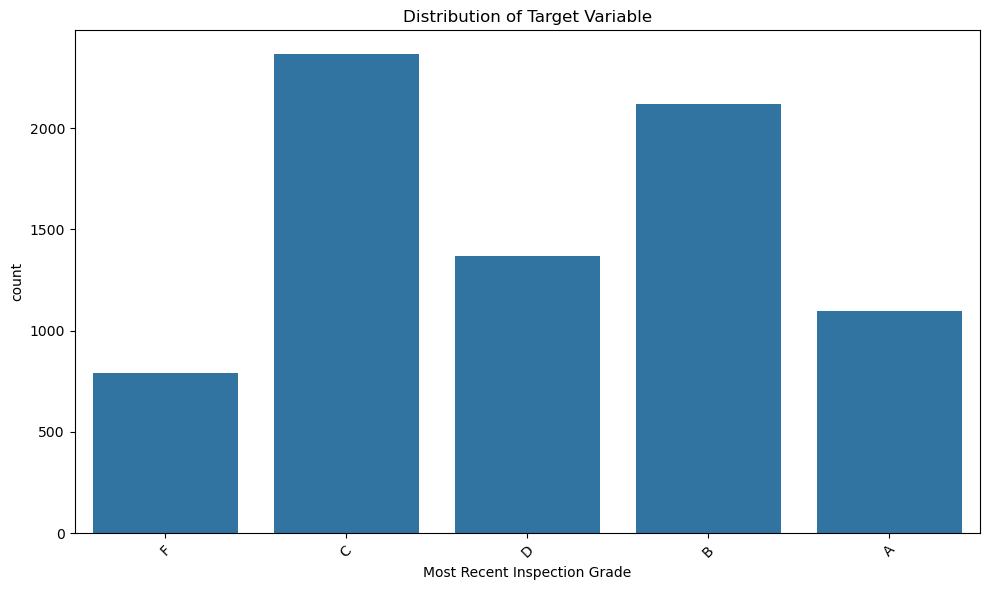

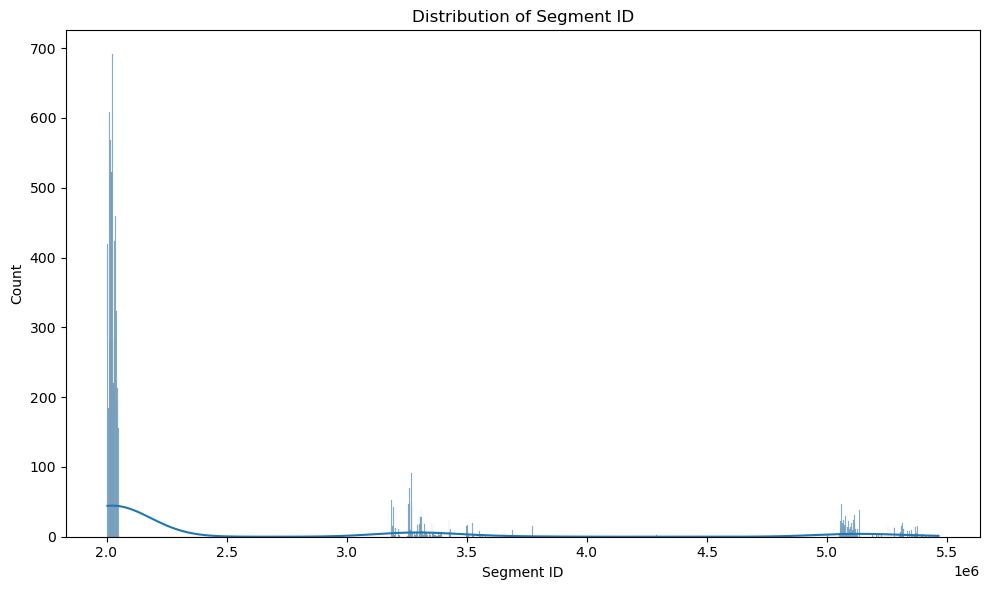

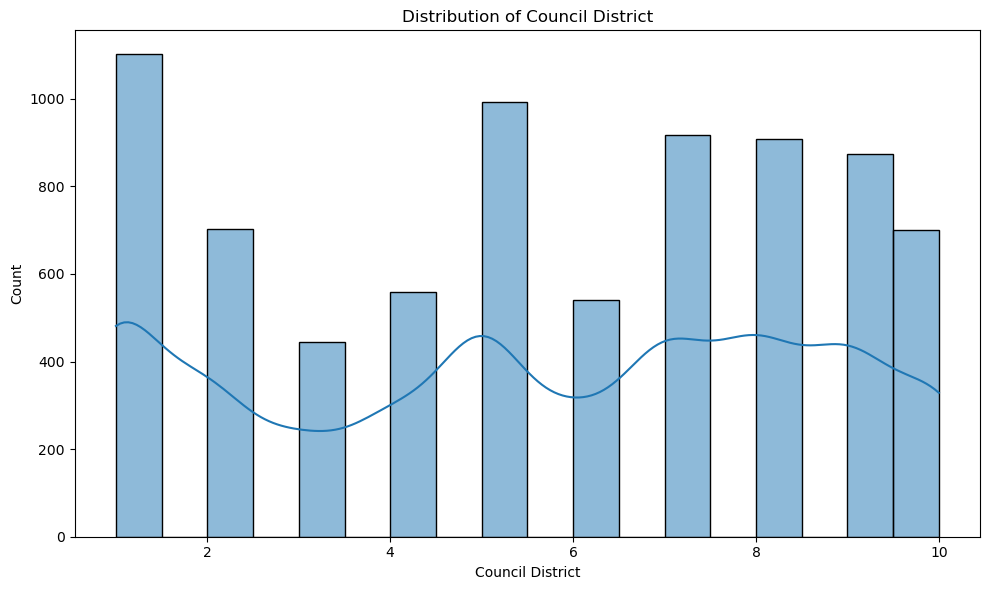

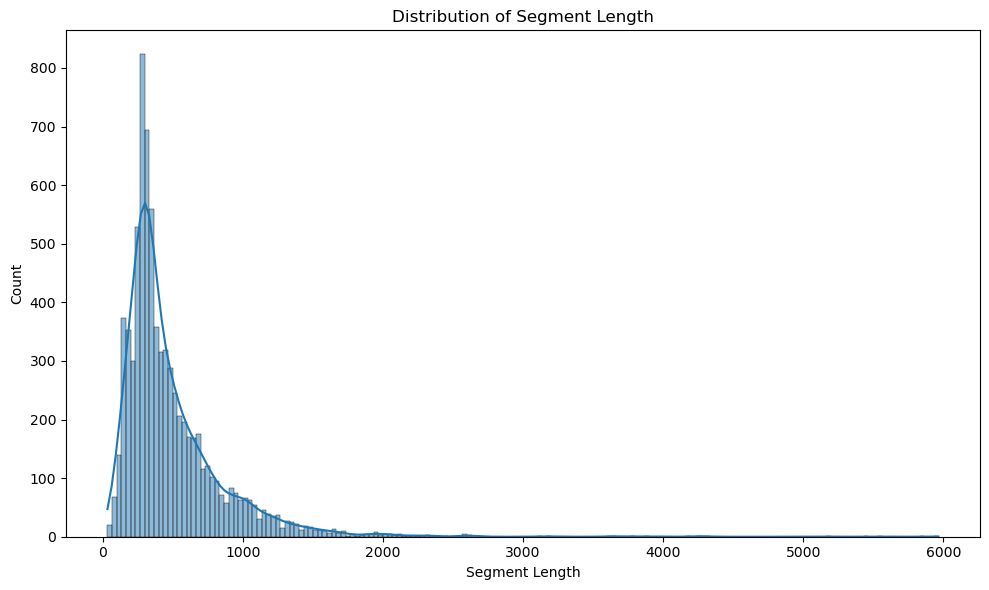

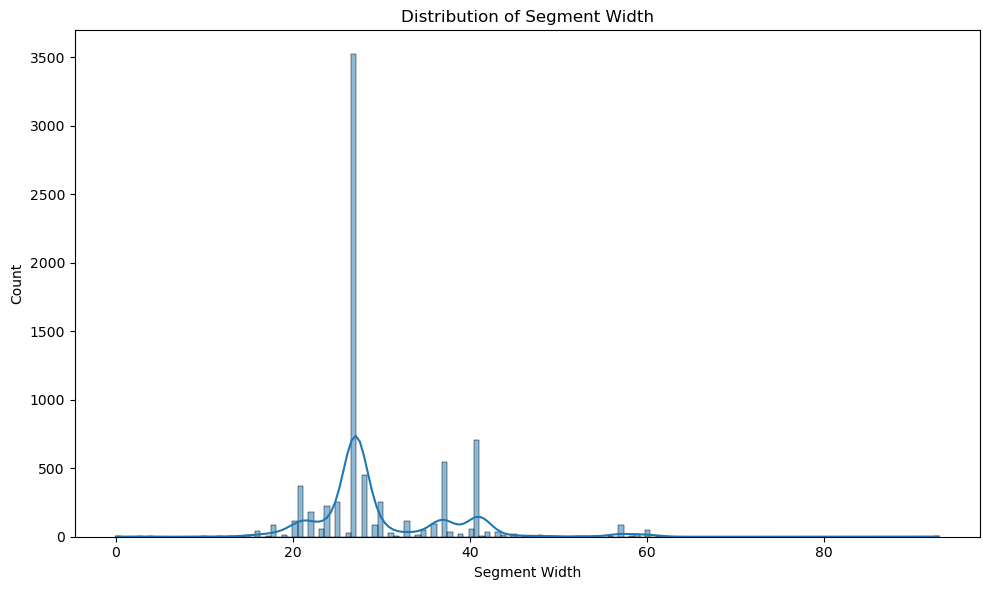

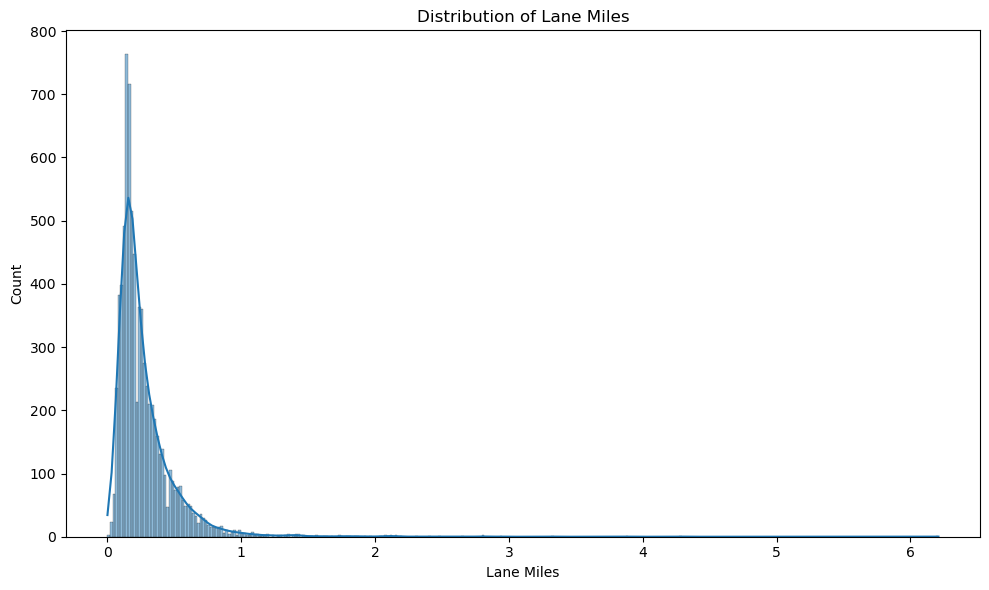

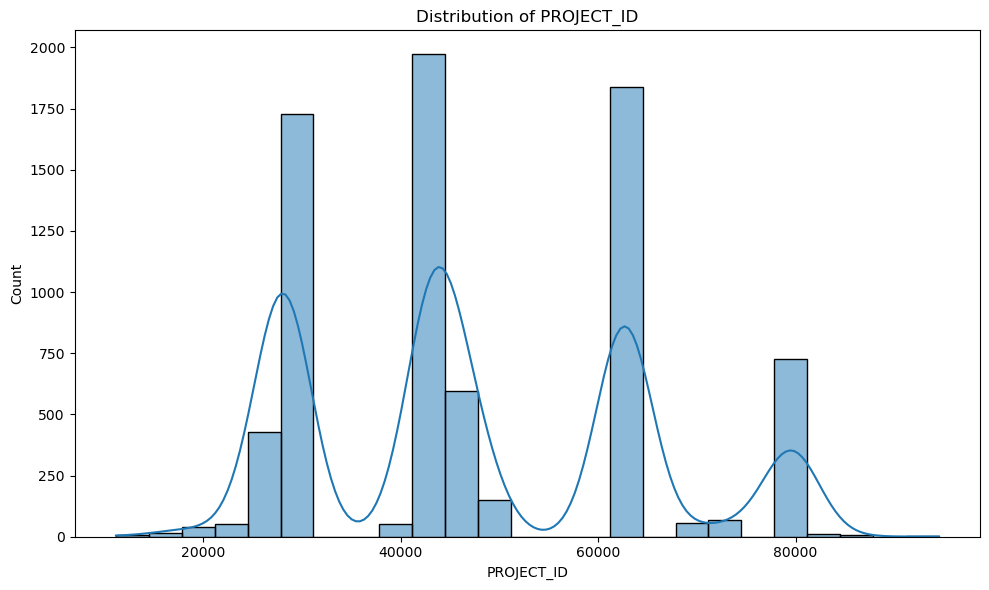

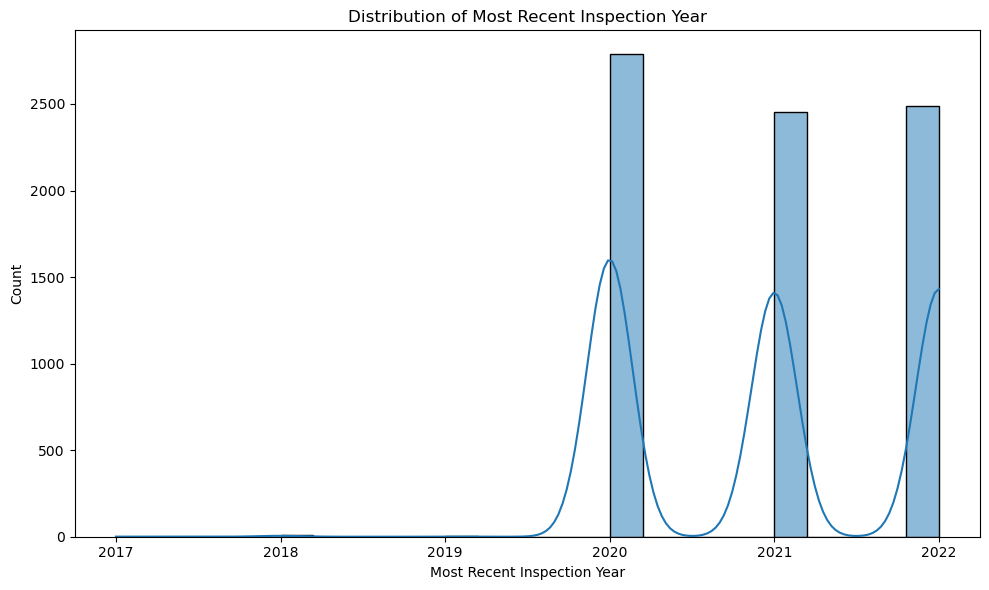

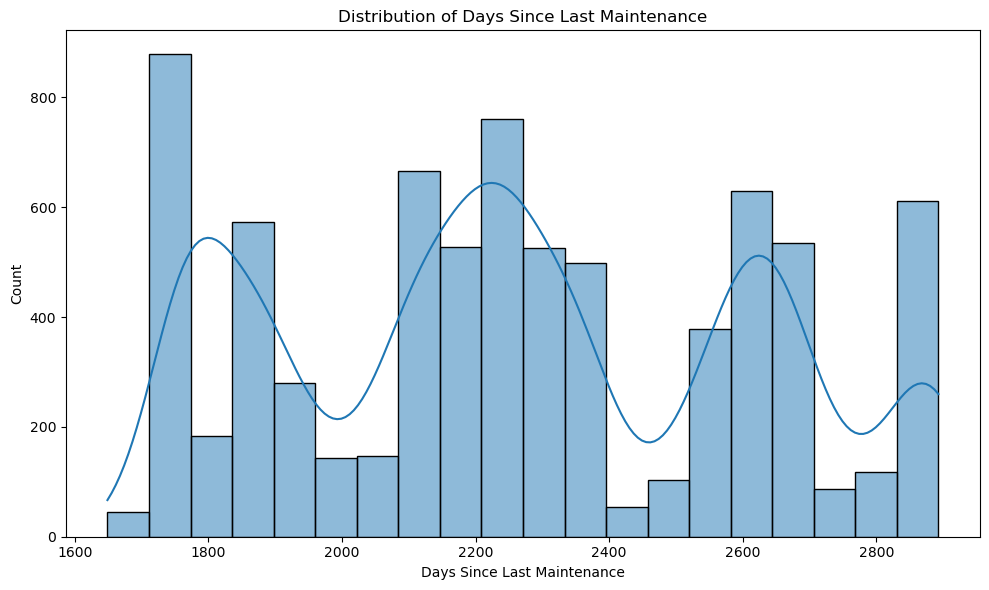

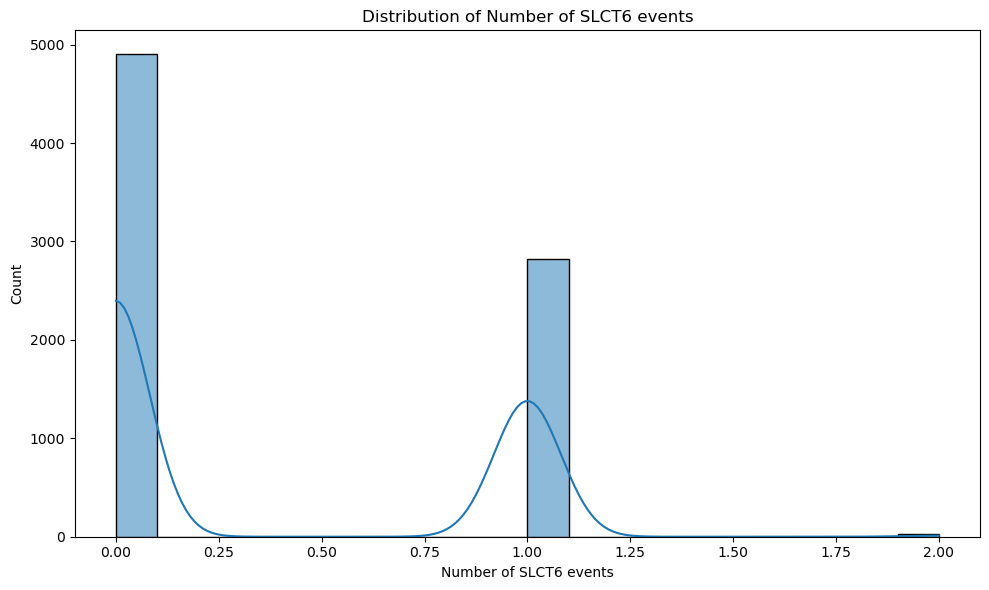

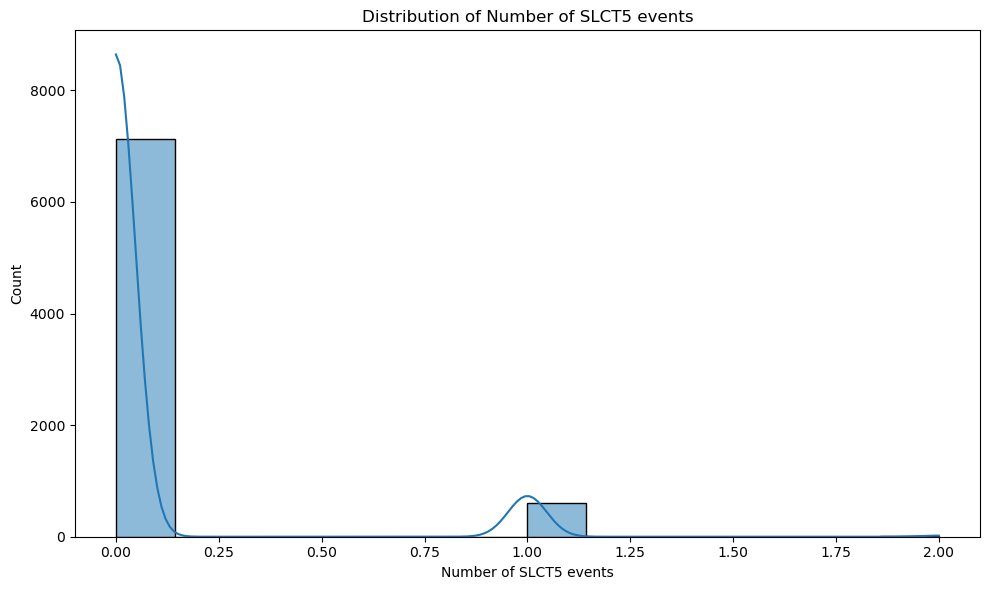

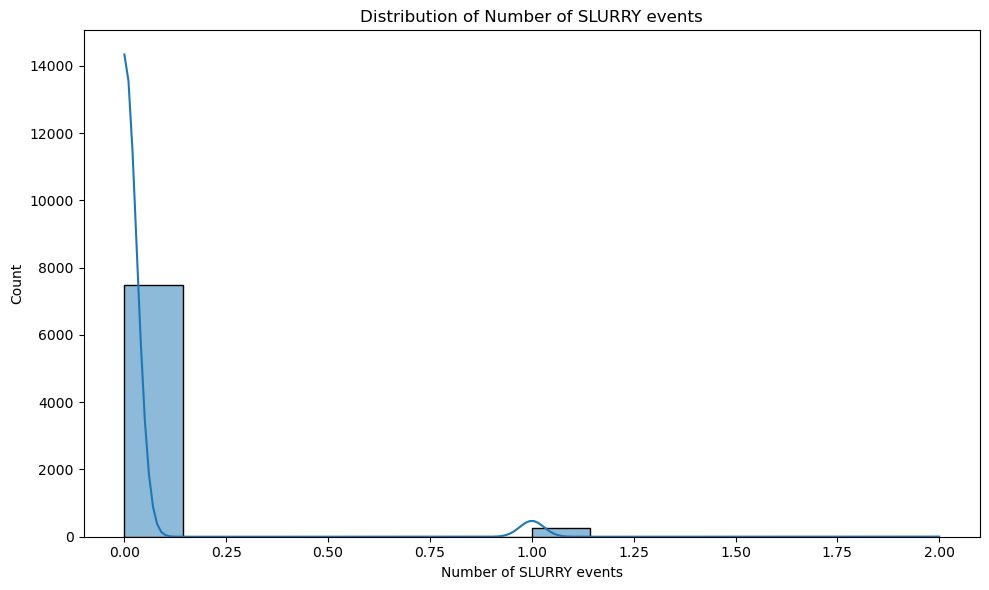

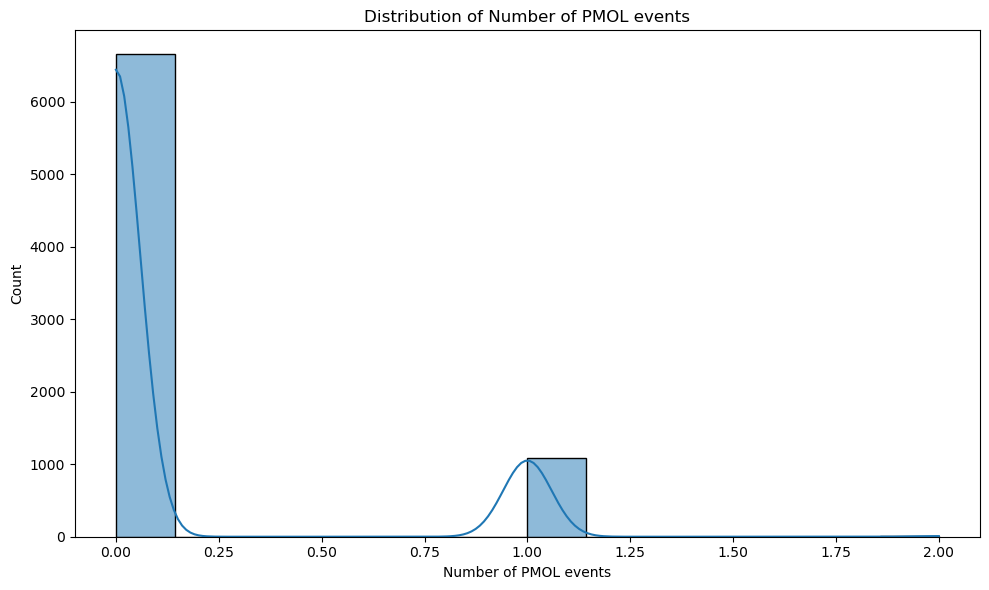

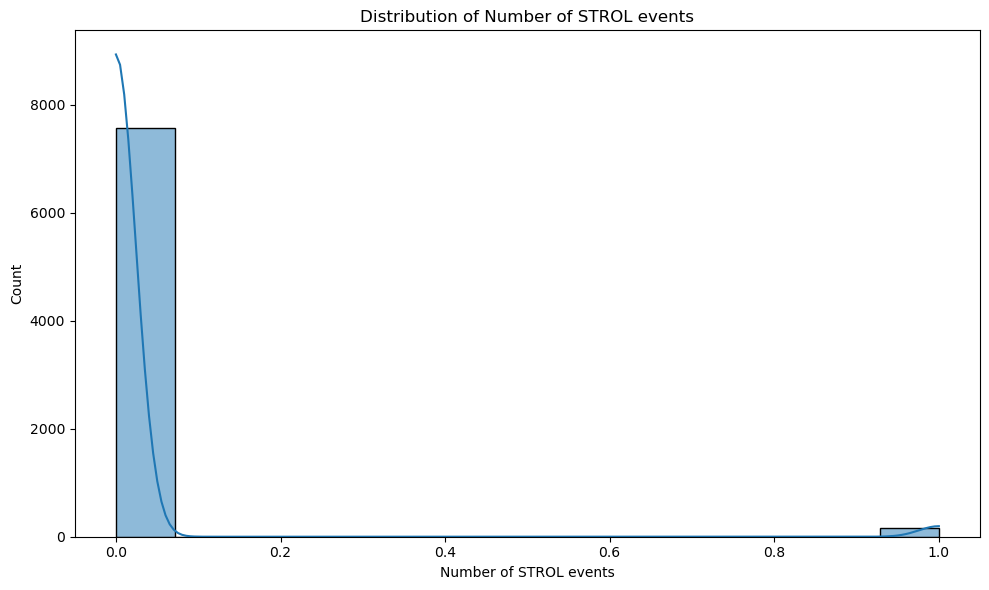

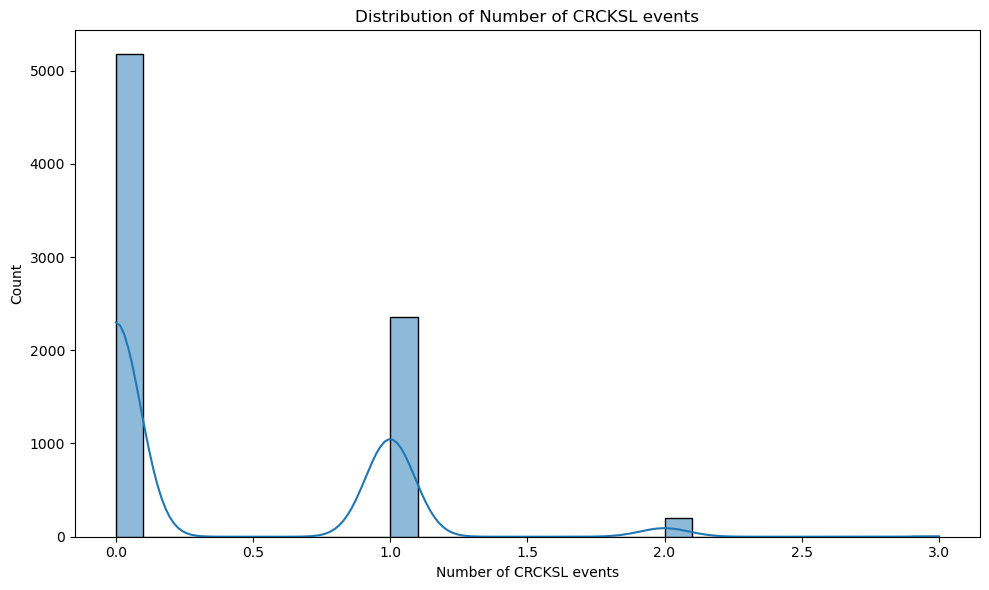

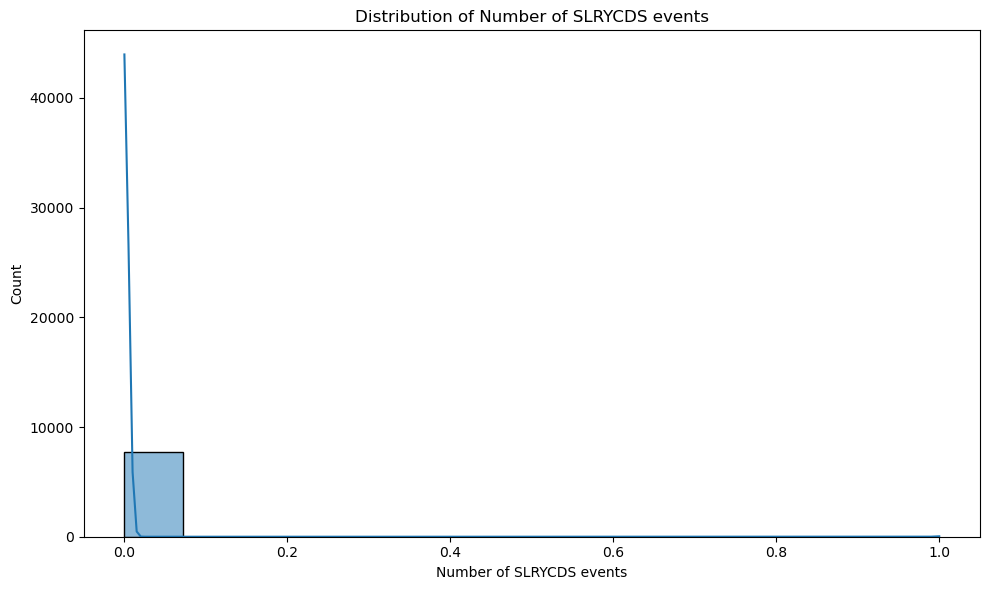

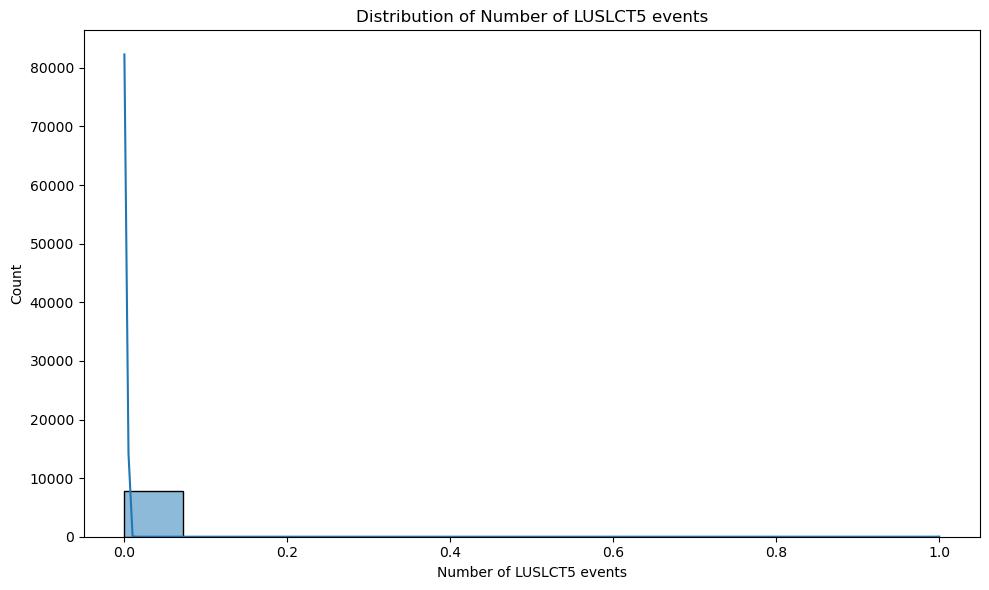

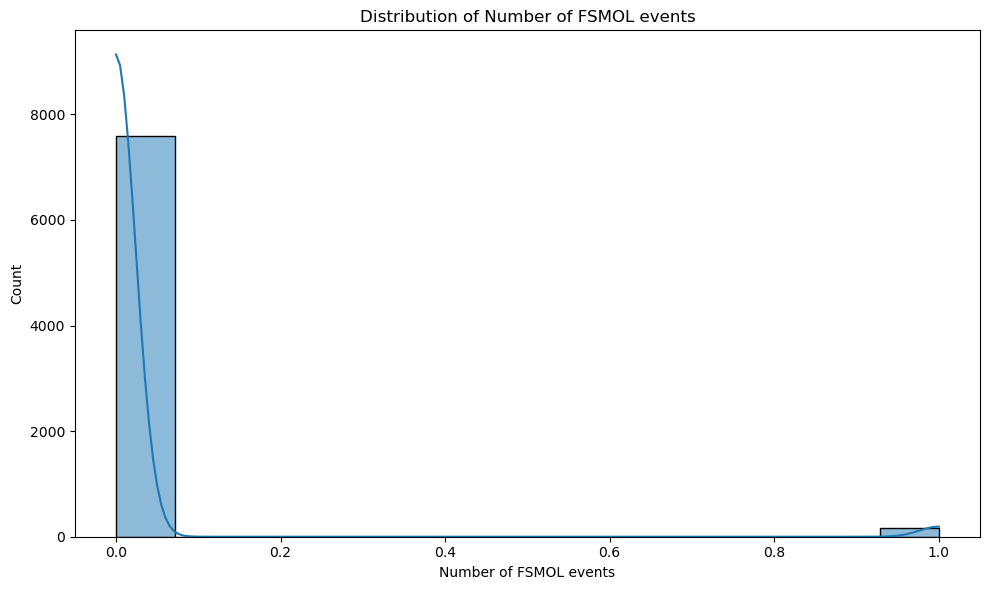

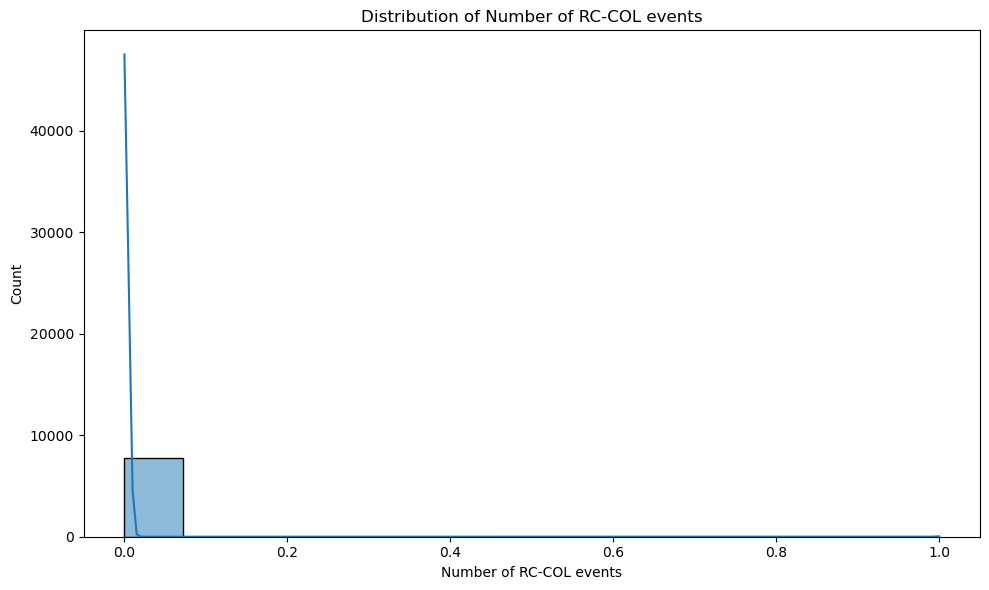

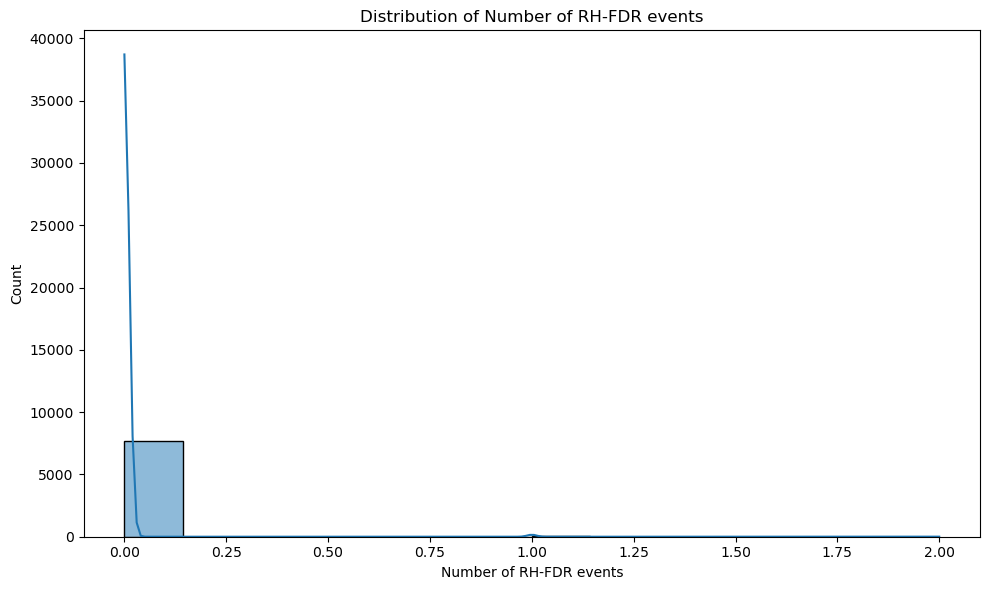

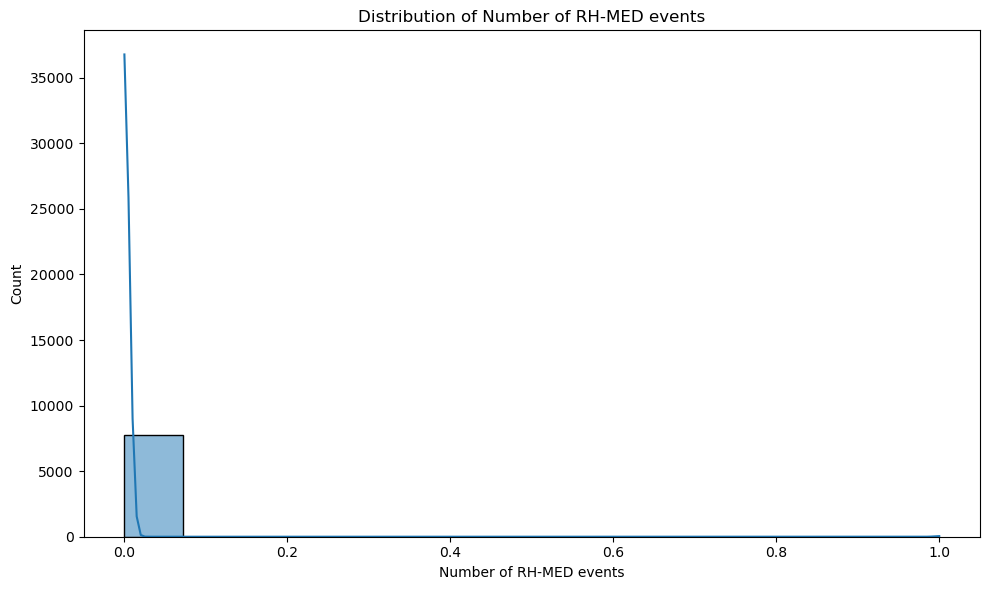

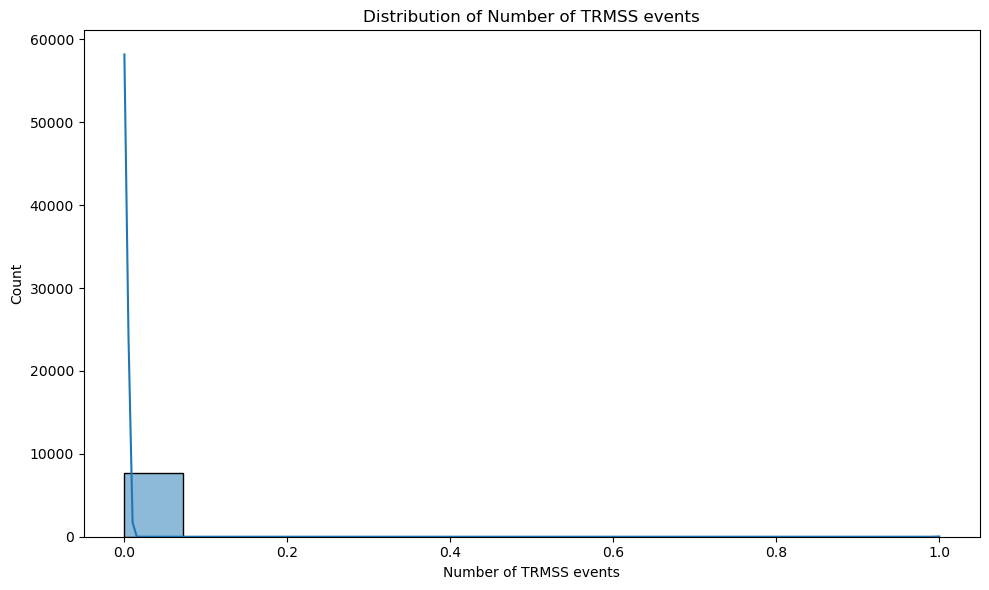

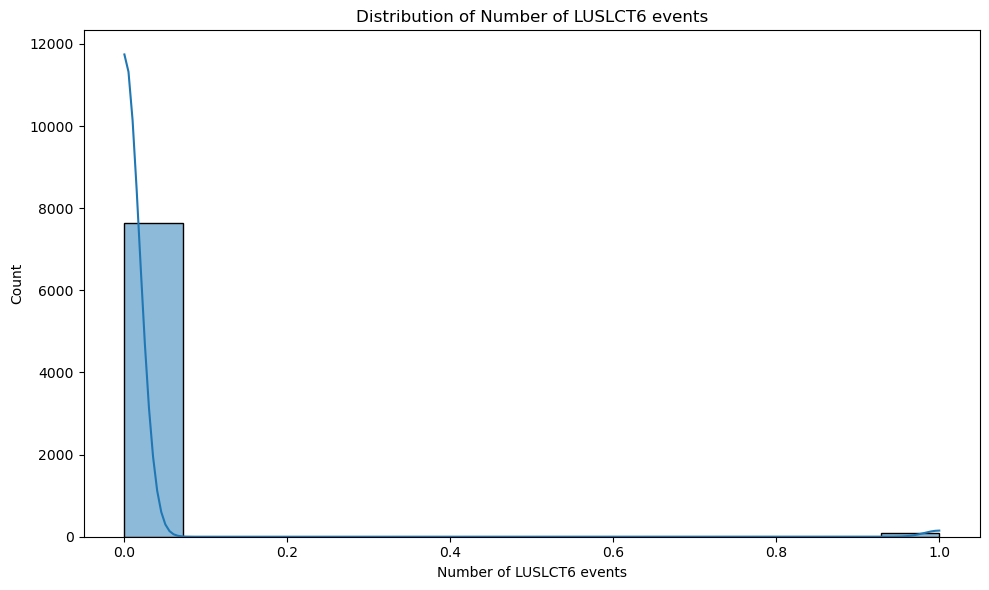

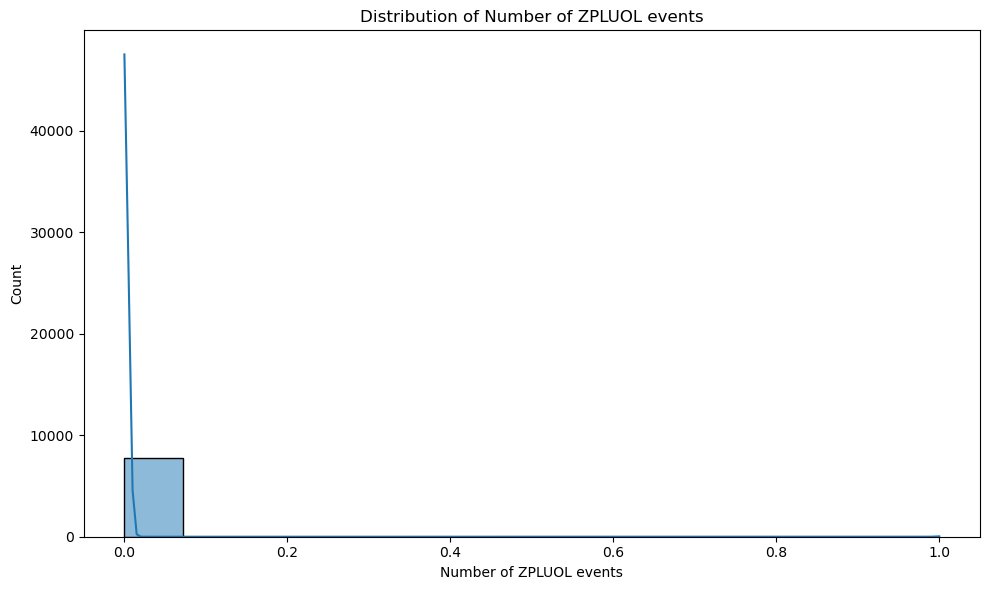

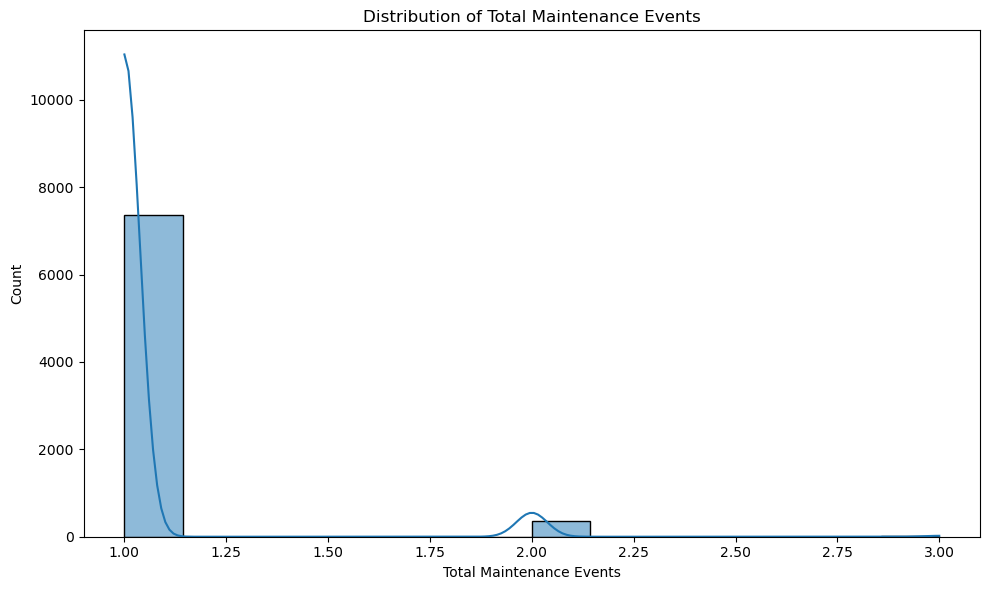

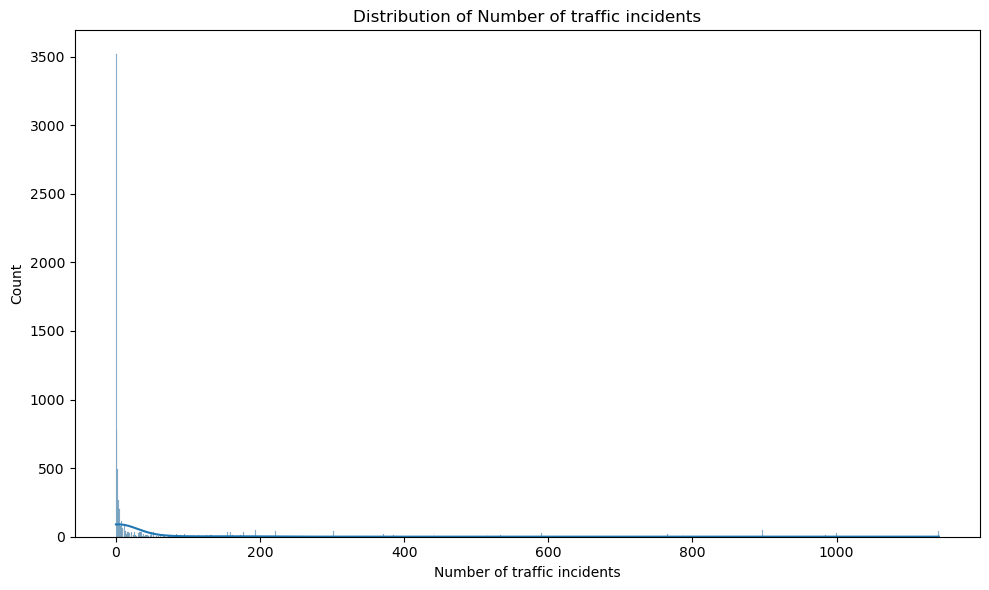

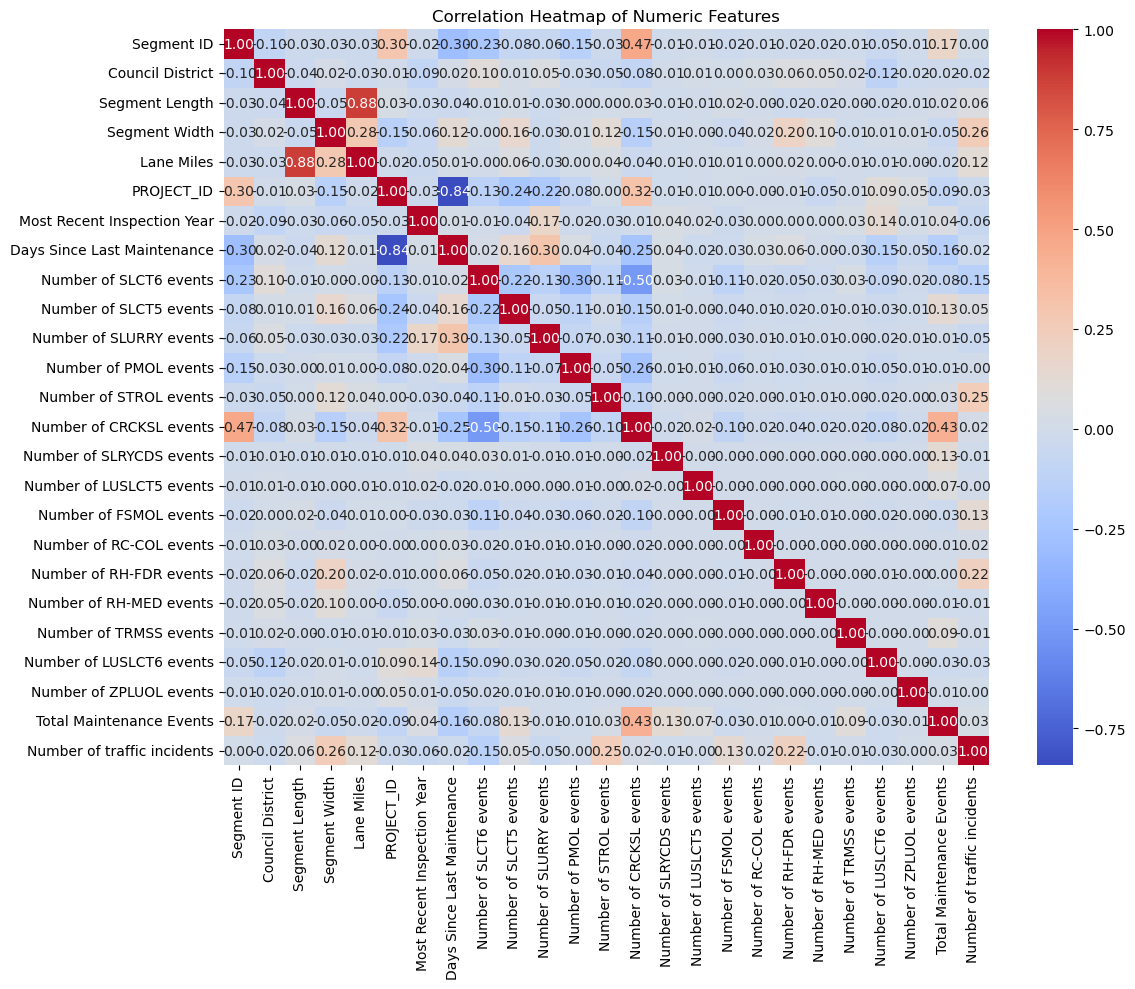

In [6]:

# Data preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load the prepared dataset
df = pd.read_csv('filtered_work_done_with_inspections_and_treatments.csv')

# Print the number of rows before dropping NaN values
print(f"Number of rows before dropping NaN values: {len(df)}")

# Drop rows with NaN values
df = df.dropna()

# Print the number of rows after dropping NaN values
print(f"Number of rows after dropping NaN values: {len(df)}")

# Define the target variable and features
target = 'Most Recent Inspection Grade'
features = df.drop(columns=[target])

# Handle missing values and encode categorical variables
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

# Explore distribution of target variable
plt.figure(figsize=(10, 6))
sns.countplot(x=target, data=df)
plt.title('Distribution of Target Variable')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Explore distributions of numeric features
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

# Check correlations between numeric features
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

# Continue with the existing code
# Define the target variable and features
target = 'Most Recent Inspection Grade'
features = df.drop(columns=[target])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

def get_feature_names(column_transformer):
    feature_names = []
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if isinstance(pipe, Pipeline):
                if isinstance(pipe.steps[-1][1], OneHotEncoder):
                    feature_names.extend(pipe.named_steps['onehot'].get_feature_names_out(features))
                else:
                    feature_names.extend(features)
            elif isinstance(pipe, OneHotEncoder):
                feature_names.extend(pipe.get_feature_names_out(features))
            else:
                feature_names.extend(features)
    return feature_names

# Fit and transform the data
X = preprocessor.fit_transform(features)
y = df[target]

# Generate feature names after fitting
feature_names = get_feature_names(preprocessor)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)


In [7]:
# Initialize variables and prepare data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import optuna

# Handle missing values in y_train and y_test
y_train_clean = y_train.fillna('Unknown')
y_test_clean = y_test.fillna('Unknown')

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_clean)
y_test_encoded = le.transform(y_test_clean)

# Get the number of classes
num_classes = len(le.classes_)
print("Number of classes:", num_classes)
print("Classes:", le.classes_)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)

# Create DataLoader objects
full_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Adjust batch size for the full dataset (you may need to experiment with this)
batch_size = 256  # Increased batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Number of classes: 5
Classes: ['A' 'B' 'C' 'D' 'F']


In [8]:
# # Naive bayes model baseline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Convert sparse matrix to dense array for Naive Bayes
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Train the model
nb_model.fit(X_train_dense, y_train)

# Make predictions on the test set
y_pred = nb_model.predict(X_test_dense)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculate and print the accuracy
accuracy = nb_model.score(X_test_dense, y_test)
print(f"\nAccuracy: {accuracy:.4f}")

# Calculate feature importance based on the variance of the features for each class
feature_importance = np.sum(nb_model.var_, axis=0)

# Print the top 10 most important features
top_features = np.argsort(feature_importance)[-10:][::-1]
print("\nTop 10 Most Important Features:")
for idx in top_features:
    print(f"{feature_names[idx]}: {feature_importance[idx]:.4f}")


Classification Report:
              precision    recall  f1-score   support

           A       0.36      0.61      0.45       221
           B       0.35      0.16      0.22       394
           C       0.35      0.08      0.13       477
           D       0.21      0.15      0.17       285
           F       0.17      0.65      0.26       172

    accuracy                           0.25      1549
   macro avg       0.29      0.33      0.25      1549
weighted avg       0.30      0.25      0.22      1549


Confusion Matrix:
[[135  14   6  11  55]
 [120  62  42  45 125]
 [ 70  75  39  83 210]
 [ 33  17  17  43 175]
 [ 16  10   8  26 112]]

Accuracy: 0.2524

Top 10 Most Important Features:
Number of TRMSS events: 8.3941
Number of RH-FDR events: 7.7106
Number of LUSLCT5 events: 6.4617
Number of traffic incidents: 5.9241
Total Maintenance Events: 5.6380
Number of RH-MED events: 5.4980
Number of STROL events: 5.3577
Number of SLCT5 events: 5.3241
Number of LUSLCT6 events: 5.1858
Segment Wi

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout_rate=0.0):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))  # Add BatchNorm
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class MLPModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden_layers, lr, dropout_rate, l1_strength=0.0, l2_strength=0.0):
        super(MLPModel, self).__init__()
        self.save_hyperparameters()
        self.model = MLP(input_dim, output_dim, hidden_layers, dropout_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=output_dim)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=output_dim)
        self.l1_strength = l1_strength
        self.l2_strength = l2_strength
    
    def forward(self, x):
        return self.model(x)
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Add L1 regularization
        if self.l1_strength > 0:
            l1_reg = sum(p.abs().sum() for p in self.model.parameters())
            loss += self.l1_strength * l1_reg
        
        self.log('train_loss', loss)
        self.train_accuracy(y_hat, y)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        self.val_accuracy(y_hat, y)
        self.log('val_acc', self.val_accuracy, on_step=True, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.l2_strength)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_acc",
                "frequency": 1
            },
        }

class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)


In [10]:
# Define optuna objective function

def objective(trial):
    # Define hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    n_layers = trial.suggest_int('n_layers', 1, 5)
    hidden_layers = [trial.suggest_int(f'n_units_l{i}', 32, 128) for i in range(n_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 1.0)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    l1_strength = trial.suggest_float('l1_strength', 1e-8, 1e-4, log=True)
    l2_strength = trial.suggest_float('l2_strength', 1e-8, 1e-4, log=True)

    # Create model with trial hyperparameters
    model = MLPModel(
        input_dim=X_train_tensor.shape[1],
        output_dim=num_classes,
        hidden_layers=hidden_layers,
        lr=lr,
        dropout_rate=dropout_rate,
        l1_strength=l1_strength,
        l2_strength=l2_strength
    )
    
    # Create DataLoader with trial's batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create trainer
    early_stop_callback = pl.callbacks.EarlyStopping(
        monitor='val_acc',
        min_delta=0.00,
        patience=10,
        verbose=False,
        mode='max'
    )
    
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        enable_progress_bar=False,
        logger=False,
        callbacks=[early_stop_callback]
    )
    
    # Train and validate
    trainer.fit(model, train_loader, val_loader)
    
    # Get the best validation accuracy
    best_val_acc = trainer.callback_metrics['val_acc'].item()
    
    return best_val_acc


In [11]:


# Optuna study and model training

import torch

# Add this line at the beginning of your script
torch.set_float32_matmul_precision('medium')

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_intermediate_values
)

# Your existing code for creating and optimizing the study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20, timeout=3600)  # 1 hour timeout

# Print best hyperparameters and score
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# Create and display visualizations
fig = plot_optimization_history(study)
fig.show()

fig = plot_param_importances(study)
fig.show()

fig = plot_parallel_coordinate(study)
fig.show()

fig = plot_intermediate_values(study)
fig.show()


# Train final model with best hyperparameters
best_params = study.best_params
best_model = MLPModel(
    input_dim=X_train_tensor.shape[1],
    output_dim=num_classes,
    hidden_layers=[best_params[f'n_units_l{i}'] for i in range(best_params['n_layers'])],
    lr=best_params['lr'],
    dropout_rate=best_params['dropout_rate']
)

# Create DataLoader with best batch size
best_batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Create the metrics callback
metrics_callback = MetricsCallback()

final_trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    enable_progress_bar=True,
    logger=True,
    callbacks=[metrics_callback]  # Add the metrics callback here
)

final_trainer.fit(best_model, train_loader, val_loader)

print("Final training completed.")
print(final_trainer.callback_metrics)

# Access specific metrics
val_loss = final_trainer.callback_metrics['val_loss'].item()
val_acc = final_trainer.callback_metrics['val_acc'].item()
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")



[I 2024-09-04 08:09:08,649] A new study created in memory with name: no-name-47fa7e65-4780-43c8-a583-81a8402f971b
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory j:\COSC Freelance Projects\Asset-Management-Technician-Follow-Up-Paper\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | MLP                | 251 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccur

Best trial:
  Value:  0.38175949454307556
  Params: 
    lr: 0.002194963848689697
    n_layers: 4
    n_units_l0: 54
    n_units_l1: 96
    n_units_l2: 32
    n_units_l3: 127
    dropout_rate: 0.432801943167645
    batch_size: 128
    l1_strength: 7.654619886378481e-05
    l2_strength: 8.424313893860326e-05


[W 2024-09-04 08:12:53,567] You need to set up the pruning feature to utilize `plot_intermediate_values()`


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:60: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | MLP                | 157 K  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
157 K     Trainable params
0         Non-trainable params
157 K     Total params
0.630     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.

C:\Users\Zack\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\loops\fit_loop.py:298: PossibleUserWarning:

The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training e

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Final training completed.
{'train_loss': tensor(1.2091), 'train_acc': tensor(0.4456), 'train_acc_step': tensor(0.4835), 'val_loss': tensor(1.3876), 'val_acc': tensor(0.3818), 'val_acc_epoch': tensor(0.3818), 'train_acc_epoch': tensor(0.4456)}
Final Validation Loss: 1.3876
Final Validation Accuracy: 0.3818


<Figure size 1500x1000 with 0 Axes>

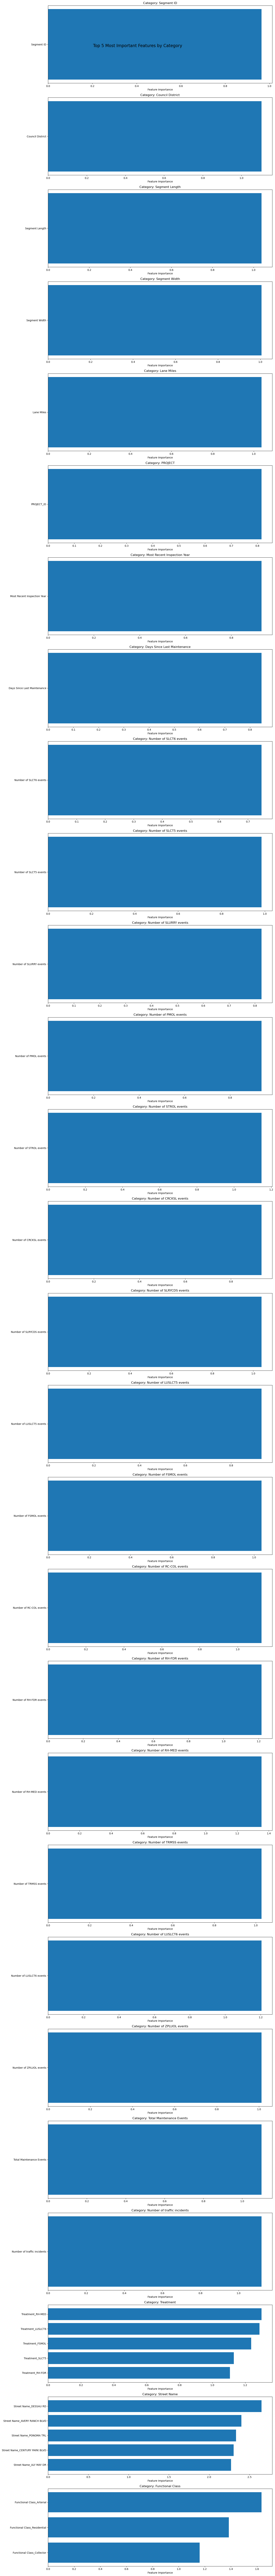

Top 5 Most Important Features by Category:

Segment ID:
Segment ID: 0.9640100002288818

Council District:
Council District: 1.1035852432250977

Segment Length:
Segment Length: 1.0386189222335815

Segment Width:
Segment Width: 1.0051051378250122

Lane Miles:
Lane Miles: 1.0375697612762451

PROJECT:
PROJECT_ID: 0.8156372308731079

Most Recent Inspection Year:
Most Recent Inspection Year: 0.931922972202301

Days Since Last Maintenance:
Days Since Last Maintenance: 0.8455759882926941

Number of SLCT6 events:
Number of SLCT6 events: 0.7477361559867859

Number of SLCT5 events:
Number of SLCT5 events: 0.984853982925415

Number of SLURRY events:
Number of SLURRY events: 0.8253489136695862

Number of PMOL events:
Number of PMOL events: 0.9381746053695679

Number of STROL events:
Number of STROL events: 1.147451639175415

Number of CRCKSL events:
Number of CRCKSL events: 0.933611273765564

Number of SLRYCDS events:
Number of SLRYCDS events: 1.0401564836502075

Number of LUSLCT5 events:
Number of

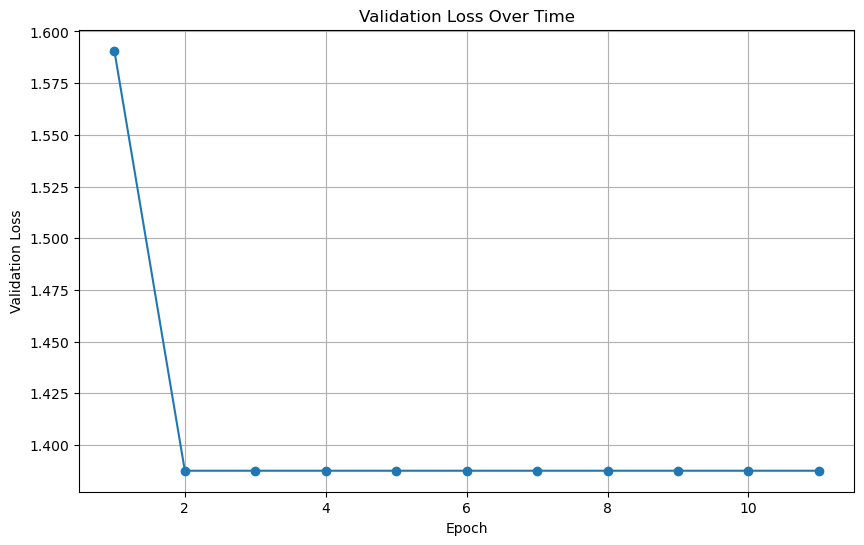


Validation Loss per Epoch:
Epoch 1: 1.5907
Epoch 2: 1.3876
Epoch 3: 1.3876
Epoch 4: 1.3876
Epoch 5: 1.3876
Epoch 6: 1.3876
Epoch 7: 1.3876
Epoch 8: 1.3876
Epoch 9: 1.3876
Epoch 10: 1.3876
Epoch 11: 1.3876

Analysis of Validation Loss:
The validation loss has decreased over time, indicating that the model is learning.
Total decrease in validation loss: 0.2031
Lowest validation loss: 1.3876 (Epoch 2)
Final validation loss: 1.3876
The validation loss increased in the final epoch, suggesting the model might be starting to overfit.


In [12]:

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def get_feature_importance(model, feature_names):
    importance = np.zeros(len(feature_names))
    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_importance = np.abs(param.detach().cpu().numpy())
            if layer_importance.ndim == 2 and layer_importance.shape[1] == len(importance):
                importance += layer_importance.sum(axis=0)
            elif layer_importance.ndim == 1 and layer_importance.shape[0] == len(importance):
                importance += layer_importance
    return importance


# Get feature importance
feature_importance = get_feature_importance(best_model.model, feature_names)

# Create a dictionary of feature names and their importance
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Group features by category
feature_categories = defaultdict(dict)
for feature, importance in feature_importance_dict.items():
    category = feature.split('_')[0]  # Assuming category is the part before the first underscore
    feature_categories[category][feature] = importance

# Select top N features from each category
N = 5  # Number of top features to select from each category
top_features_by_category = {}
for category, features in feature_categories.items():
    sorted_features = sorted(features.items(), key=lambda x: x[1], reverse=True)
    top_features_by_category[category] = sorted_features[:N]

# Plotting
plt.figure(figsize=(15, 10))
categories = list(top_features_by_category.keys())
num_categories = len(categories)
num_features = N

fig, axs = plt.subplots(num_categories, 1, figsize=(15, 5*num_categories), squeeze=False)
fig.suptitle('Top 5 Most Important Features by Category', fontsize=16)

for i, category in enumerate(categories):
    features, importances = zip(*top_features_by_category[category])
    axs[i, 0].barh(features, importances)
    axs[i, 0].set_title(f'Category: {category}')
    axs[i, 0].set_xlabel('Feature Importance')
    axs[i, 0].invert_yaxis()

plt.tight_layout()
plt.show()

# Print the top features for each category
print("Top 5 Most Important Features by Category:")
for category, features in top_features_by_category.items():
    print(f"\n{category}:")
    for feature, importance in features:
        print(f"{feature}: {importance}")

# Interpret the results
print("\nInterpretation of Results:")
print("1. We can now see the most important features across different categories.")
print("2. This provides a more balanced view of feature importance across the dataset.")
print("3. Consider the top features from each category for further analysis or feature engineering.")
print("4. Compare the importance values across categories to understand which categories have the strongest influence overall.")



# Extract validation loss from metrics
val_losses = [x['val_loss'].item() for x in metrics_callback.metrics]

# Plot validation loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='o')
plt.title('Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

# Print the validation loss for each epoch
print("\nValidation Loss per Epoch:")
for epoch, loss in enumerate(val_losses, 1):
    print(f"Epoch {epoch}: {loss:.4f}")
    
# Analyze the validation loss trend
print("\nAnalysis of Validation Loss:")
if val_losses[-1] < val_losses[0]:
    print("The validation loss has decreased over time, indicating that the model is learning.")
    print(f"Total decrease in validation loss: {val_losses[0] - val_losses[-1]:.4f}")
else:
    print("The validation loss has not decreased. The model might be overfitting or struggling to learn.")

print(f"Lowest validation loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
print(f"Final validation loss: {val_losses[-1]:.4f}")

if len(val_losses) > 1:
    if val_losses[-1] < val_losses[-2]:
        print("The validation loss decreased in the final epoch, suggesting the model might benefit from more training.")
    else:
        print("The validation loss increased in the final epoch, suggesting the model might be starting to overfit.")



